## Market Value & Performance Exploration
1. Read all required CSV files from the `data` directory.
2. Create derived columns needed for analysis (age, performance, growth rate, etc.).
3. Sequentially plot five visualizations:
   - Age vs. Market Value scatter plot (colored by position)
   - Average market value by age for each position
   - Performance (Goals+Assists per 90) vs. Market Value
   - Market value growth curves across different leagues
   - Distribution of the difference between transfer fee and market value at the time

In [ ]:

# Import all libraries required for data processing and visualization
import pandas as pd  # Core tool for DataFrame operations
import numpy as np   # Advanced numerical operations (e.g., interpolation, group calculations)
import matplotlib.pyplot as plt  # Main library for creating static visualizations
import seaborn as sns  # Provides friendlier styles and statistical plots on top of matplotlib
from pathlib import Path  # Handles path manipulations, making the notebook portable

# Set a unified visual style for all charts to ensure consistency and readability
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (12, 7) 


In [ ]:

# Define paths for all CSVs and load each required file at once
DATA_DIR = Path("..") / "data"  # The notebook is in data_visualization, so go up one level to reach the data folder
csv_files = {
    "appearances": DATA_DIR / "appearances.csv",
    "club_games": DATA_DIR / "club_games.csv",
    "clubs": DATA_DIR / "clubs.csv",
    "competitions": DATA_DIR / "competitions.csv",
    "game_events": DATA_DIR / "game_events.csv",
    "game_lineups": DATA_DIR / "game_lineups.csv",
    "games": DATA_DIR / "games.csv",
    "player_valuations": DATA_DIR / "player_valuations.csv",
    "players": DATA_DIR / "players.csv",
    "transfers": DATA_DIR / "transfers.csv",
}

# Store all DataFrames in a dictionary so you can access, e.g., dfs["players"] later
dfs = {}
for name, path in csv_files.items():
    dfs[name] = pd.read_csv(path)
    print(f"Loaded {name} with {dfs[name].shape[0]:,} rows and {dfs[name].shape[1]} columns")


Loaded appearances with 1,706,806 rows and 13 columns
Loaded club_games with 148,052 rows and 11 columns
Loaded clubs with 439 rows and 17 columns
Loaded competitions with 44 rows and 11 columns
Loaded game_events with 1,035,043 rows and 10 columns
Loaded game_lineups with 2,191,911 rows and 10 columns
Loaded games with 74,026 rows and 23 columns
Loaded player_valuations with 496,606 rows and 5 columns
Loaded players with 32,601 rows and 23 columns
Loaded transfers with 79,646 rows and 10 columns


In [ ]:

# Assign frequently used DataFrames to variables for more intuitive reading
players = dfs["players"]
player_valuations = dfs["player_valuations"]
appearances = dfs["appearances"]
competitions = dfs["competitions"]
transfers = dfs["transfers"]

# Convert date columns to datetime to enable later calculations (age, time difference, year)
players["date_of_birth"] = pd.to_datetime(players["date_of_birth"], errors="coerce")
player_valuations["date"] = pd.to_datetime(player_valuations["date"], errors="coerce")
appearances["date"] = pd.to_datetime(appearances["date"], errors="coerce")
transfers["transfer_date"] = pd.to_datetime(transfers["transfer_date"], errors="coerce")

# Set up a common unit conversion: all market values in charts below will be shown in million euros to avoid overly large numbers
MILLION = 1_000_000


### 1. Player Age vs Market Value Scatter Plot (Colored by Position)

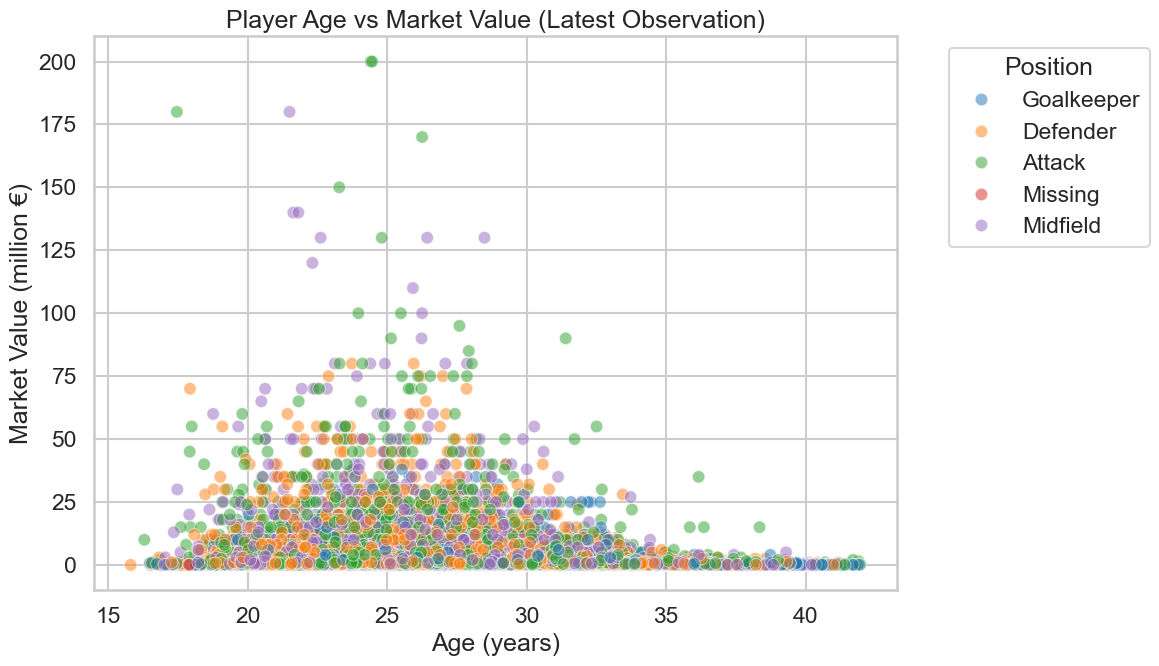

In [ ]:

# Take the most recent market value for each player, representing their current value
latest_values = (
    player_valuations.sort_values("date")  # Sort by date so that drop_duplicates keeps the latest value
    .dropna(subset=["market_value_in_eur"])  # Remove records without market value; these are not useful for the scatter plot
    .drop_duplicates(subset="player_id", keep="last")
)

# Merge the latest valuation with player master data to get position and date of birth
latest_with_meta = latest_values.merge(
    players[["player_id", "position", "sub_position", "date_of_birth", "name"]],
    on="player_id",
    how="inner"
)

# Calculate each player's age at the time of the latest valuation by dividing the day difference by 365.25
latest_with_meta = latest_with_meta.dropna(subset=["date_of_birth", "date"])
latest_with_meta["age_years"] = (
    (latest_with_meta["date"] - latest_with_meta["date_of_birth"]).dt.days / 365.25
)

# Restrict age to a reasonable range for professional players (15~42), and convert market value to millions of euros
age_value_scatter = latest_with_meta.query("15 <= age_years <= 42").copy()
age_value_scatter["value_million"] = age_value_scatter["market_value_in_eur"] / MILLION

# Create scatter plot: X axis is age, Y axis is market value, color represents position
plt.figure()
sns.scatterplot(
    data=age_value_scatter,
    x="age_years",
    y="value_million",
    hue="position",
    alpha=0.5,
    palette="tab10"
)
plt.title("Player Age vs Market Value (Latest Observation)")
plt.xlabel("Age (years)")
plt.ylabel("Market Value (million €)")
plt.legend(title="Position", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


### 2. Average Market Value by Age Curve for Different Positions

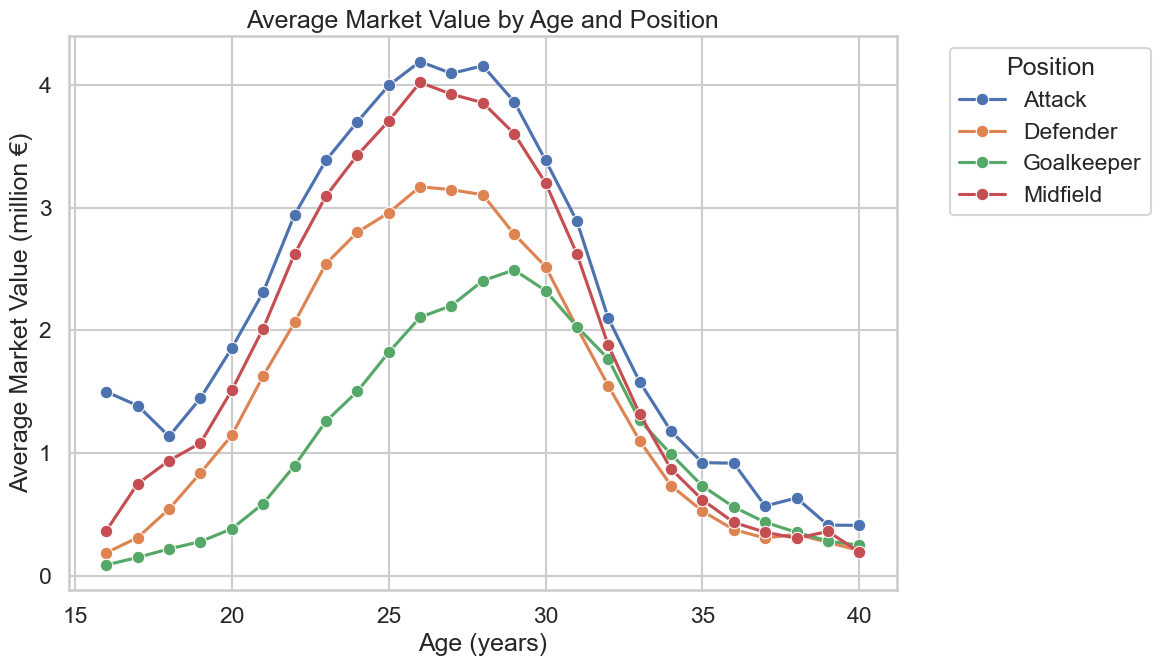

In [17]:

# To observe how market value changes with age, use all valuation records and average by age
age_value_curve = (
    player_valuations.dropna(subset=["market_value_in_eur", "date"])  # Ensure age and valuation are present
    .merge(players[["player_id", "position", "date_of_birth"]], on="player_id", how="inner")
)
age_value_curve = age_value_curve.dropna(subset=["date_of_birth"])
age_value_curve["age_years"] = (
    (age_value_curve["date"] - age_value_curve["date_of_birth"]).dt.days / 365.25
)

# Take the four primary positions and round age to an integer for a smooth, readable curve
primary_positions = ["Attack", "Midfield", "Defender", "Goalkeeper"]
age_value_curve = age_value_curve[age_value_curve["position"].isin(primary_positions)]
age_value_curve["age_int"] = age_value_curve["age_years"].round().astype(int)

# Group by age and position to calculate average market value
avg_value_by_age = (
    age_value_curve.query("16 <= age_int <= 40")
    .groupby(["position", "age_int"])["market_value_in_eur"].mean()
    .reset_index()
)
avg_value_by_age["value_million"] = avg_value_by_age["market_value_in_eur"] / MILLION

plt.figure()
sns.lineplot(
    data=avg_value_by_age,
    x="age_int",
    y="value_million",
    hue="position",
    marker="o"
)
plt.title("Average Market Value by Age and Position")
plt.xlabel("Age (years)")
plt.ylabel("Average Market Value (million €)")
plt.legend(title="Position", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


### 3. Performance vs Market Value

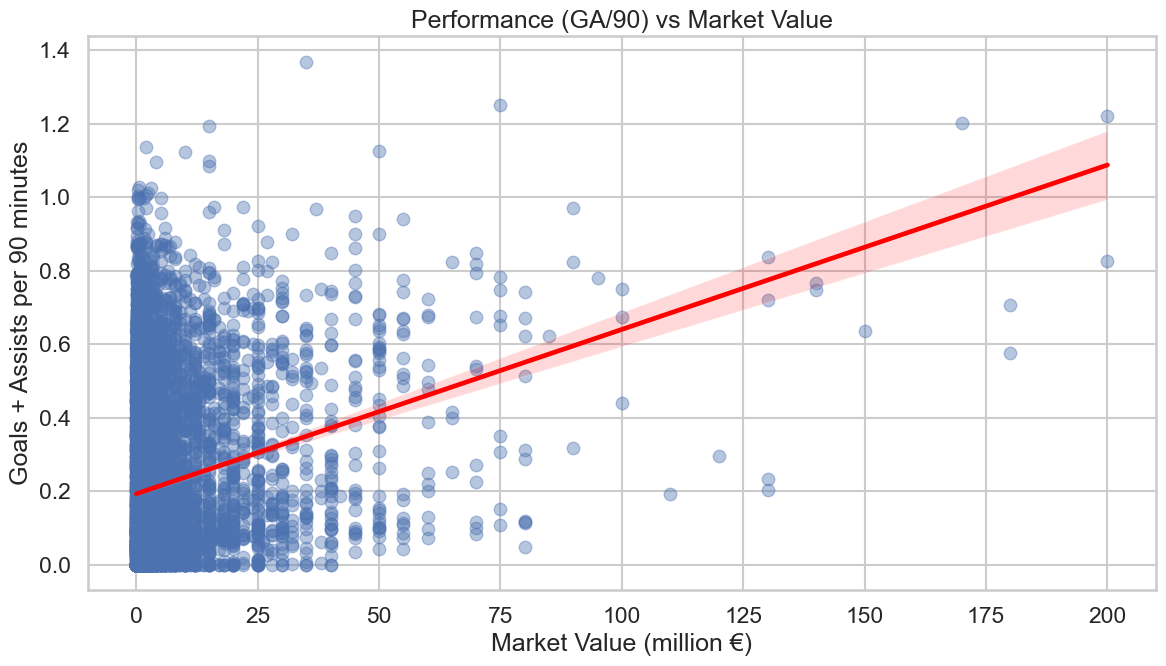

In [23]:

# Use the appearances table to calculate each player's cumulative performance: total goals, assists, and minutes played
performance = (
    appearances.groupby("player_id")[["goals", "assists", "minutes_played"]].sum().reset_index()
)
performance.rename(columns={"goals": "total_goals", "assists": "total_assists", "minutes_played": "total_minutes"}, inplace=True)

# Create the Goals+Assists per 90 minutes metric, and filter out players with insufficient minutes to reduce noise
performance = performance[performance["total_minutes"] > 0]
performance["ga_per_90"] = (performance["total_goals"] + performance["total_assists"]) / (performance["total_minutes"] / 90)
performance_filtered = performance[performance["total_minutes"] >= 900]

# Merge the performance metrics with the latest valuation to get market value information
performance_market = performance_filtered.merge(
    age_value_scatter[["player_id", "value_million"]],
    on="player_id",
    how="inner"
)

plt.figure()
sns.regplot(
    data=performance_market,
    x="value_million",
    y="ga_per_90",
    
    scatter_kws={"alpha": 0.4},
    line_kws={"color": "red"}
)
plt.title("Performance (GA/90) vs Market Value")
plt.ylabel("Goals + Assists per 90 minutes")
plt.xlabel("Market Value (million €)")
plt.tight_layout()
plt.show()


### 4. Market Value Growth vs League

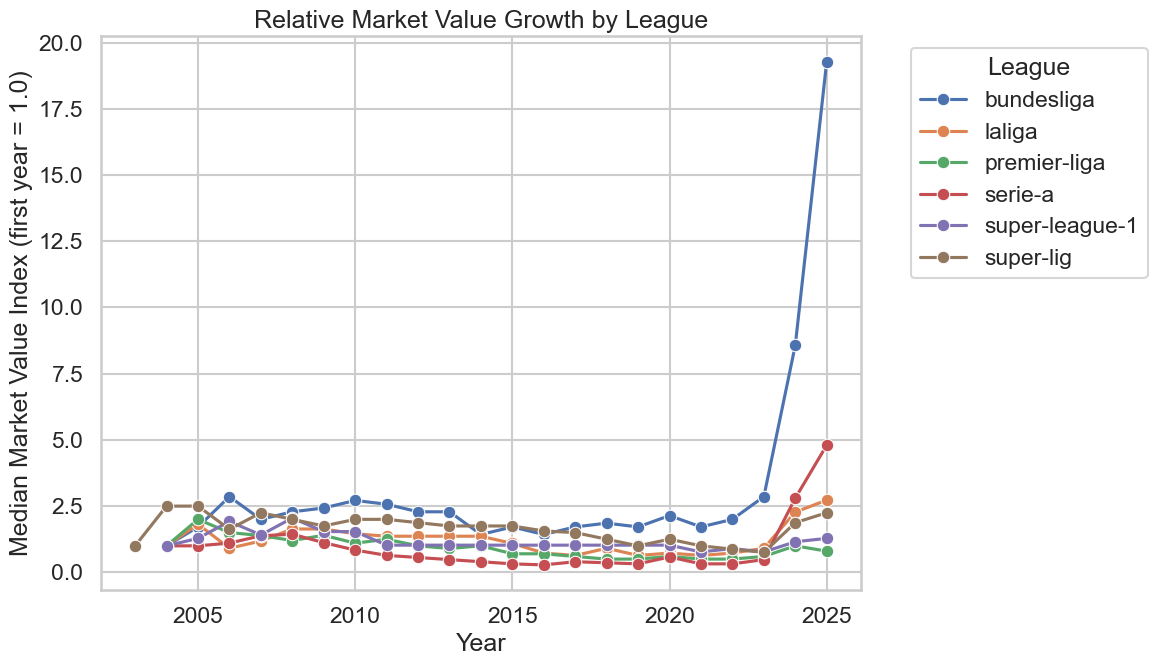

In [ ]:

# First, add league information to the valuation data (from competitions) for easier human-readable league names
league_values = player_valuations.merge(
    competitions[["competition_id", "name"]],
    left_on="player_club_domestic_competition_id",
    right_on="competition_id",
    how="left"
)
league_values = league_values.dropna(subset=["date", "market_value_in_eur", "name"])
league_values["year"] = league_values["date"].dt.year

# Select the top 6 leagues with the most valuation records to ensure stable trends
major_leagues = (
    league_values["name"].value_counts().head(6).index.tolist()
)
league_values = league_values[league_values["name"].isin(major_leagues)]

# Calculate the median market value for each league and year, and convert to a growth index based on the first year
league_yearly = (
    league_values.groupby(["name", "year"])["market_value_in_eur"].median().reset_index()
)
league_yearly.sort_values(["name", "year"], inplace=True)
league_yearly["growth_index"] = league_yearly.groupby("name")["market_value_in_eur"].transform(
    lambda s: s / s.iloc[0] if s.iloc[0] != 0 else np.nan
)

plt.figure()
sns.lineplot(
    data=league_yearly,
    x="year",
    y="growth_index",
    hue="name",
    marker="o"
)
plt.title("Relative Market Value Growth by League")
plt.xlabel("Year")
plt.ylabel("Median Market Value Index (first year = 1.0)")
plt.legend(title="League", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


### 5. Transfer fee vs Market Value: Distribution of Differences at Time of Transfer

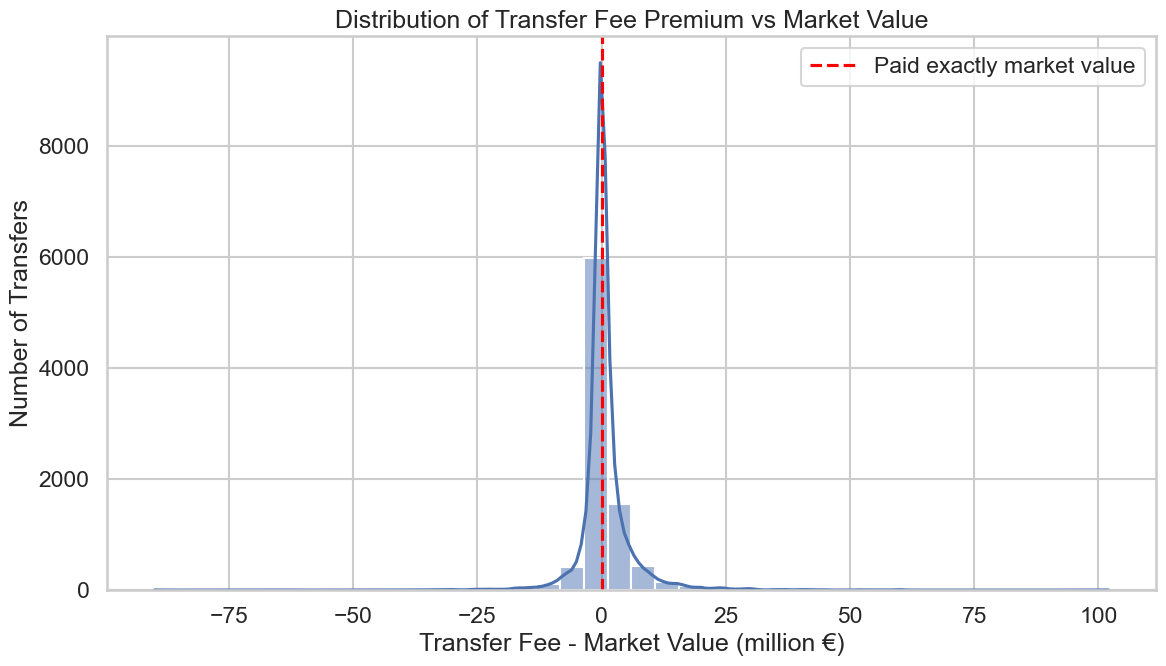

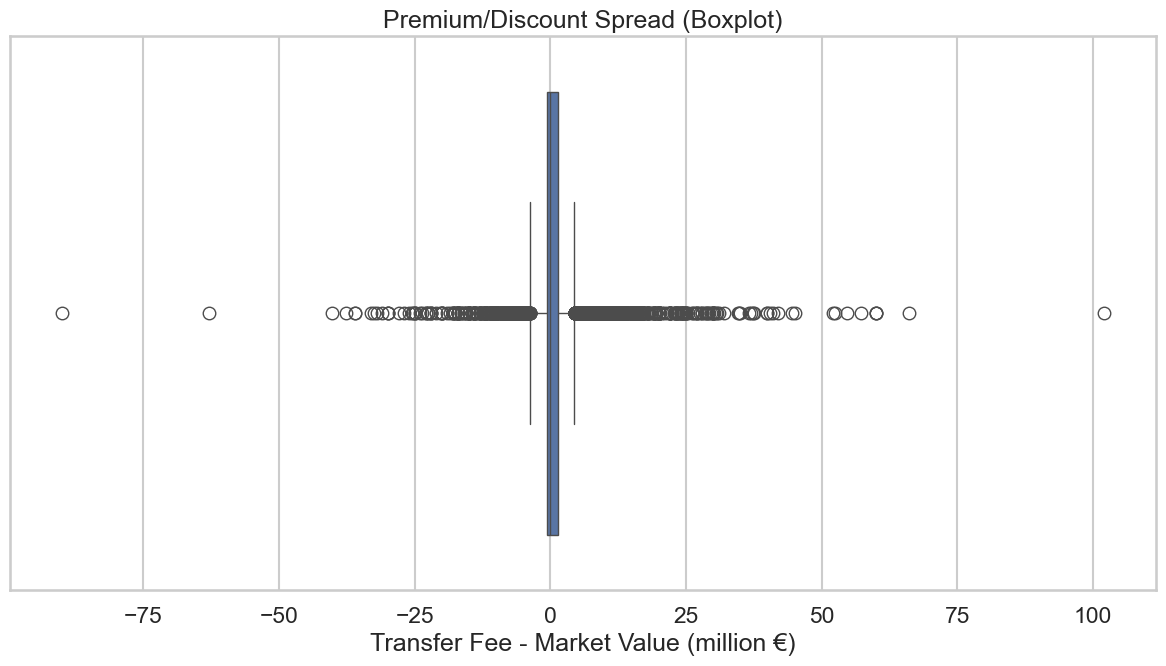

In [ ]:

# Clean transfer data: only keep records with both transfer fee and market value available
transfer_clean = transfers.dropna(subset=["transfer_fee", "market_value_in_eur"])
transfer_clean = transfer_clean[transfer_clean["transfer_fee"] > 0]

# Calculate the difference and ratio between transfer fee and market value to judge premium or discount
transfer_clean["fee_minus_value"] = transfer_clean["transfer_fee"] - transfer_clean["market_value_in_eur"]
transfer_clean["diff_million"] = transfer_clean["fee_minus_value"] / MILLION
transfer_clean["pct_diff"] = transfer_clean["fee_minus_value"] / transfer_clean["market_value_in_eur"]

plt.figure()
sns.histplot(transfer_clean["diff_million"], bins=40, kde=True)
plt.axvline(0, color="red", linestyle="--", label="Paid exactly market value")
plt.title("Distribution of Transfer Fee Premium vs Market Value")
plt.xlabel("Transfer Fee - Market Value (million €)")
plt.ylabel("Number of Transfers")
plt.legend()
plt.tight_layout()
plt.show()

# Add a boxplot to quickly identify premium/discount outliers
plt.figure()
sns.boxplot(x=transfer_clean["diff_million"])
plt.title("Premium/Discount Spread (Boxplot)")
plt.xlabel("Transfer Fee - Market Value (million €)")
plt.tight_layout()
plt.show()


In [19]:
competitions.head()

,competition_id,competition_code,name,sub_type,type,country_id,country_name,domestic_league_code,confederation,url,is_major_national_league
0,CIT,italy-cup,italy-cup,domestic_cup,domestic_cup,75,Italy,IT1,europa,https://www.transfermarkt.co.uk/italy-cup/star...,False
1,NLSC,johan-cruijff-schaal,johan-cruijff-schaal,domestic_super_cup,other,122,Netherlands,NL1,europa,https://www.transfermarkt.co.uk/johan-cruijff-...,False
2,GRP,kypello-elladas,kypello-elladas,domestic_cup,domestic_cup,56,Greece,GR1,europa,https://www.transfermarkt.co.uk/kypello-ellada...,False
3,POSU,supertaca-candido-de-oliveira,supertaca-candido-de-oliveira,domestic_super_cup,other,136,Portugal,PO1,europa,https://www.transfermarkt.co.uk/supertaca-cand...,False
4,RUSS,russian-super-cup,russian-super-cup,domestic_super_cup,other,141,Russia,RU1,europa,https://www.transfermarkt.co.uk/russian-super-...,False


In [24]:
appearances.describe()

,game_id,player_id,player_club_id,player_current_club_id,date,yellow_cards,red_cards,goals,assists,minutes_played
count,1.706806e+06,1.706806e+06,1.706806e+06,1.706806e+06,1706806,1.706806e+06,1.706806e+06,1.706806e+06,1.706806e+06,1.706806e+06
mean,3.166096e+06,2.099745e+05,3.138290e+03,3.991235e+03,2019-01-03 08:03:23.124667392,1.472329e-01,3.783090e-03,9.589432e-02,7.549540e-02,6.906125e+01
min,2.211607e+06,1.000000e+01,1.000000e+00,-1.000000e+00,2012-07-03 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,2.589007e+06,5.840200e+04,2.890000e+02,3.310000e+02,2015-10-20 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.500000e+01
50%,3.080787e+06,1.495770e+05,8.260000e+02,9.030000e+02,2019-01-04 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+01
75%,3.621597e+06,3.066680e+05,2.441000e+03,2.696000e+03,2022-04-02 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+01
max,4.572898e+06,1.380876e+06,1.103020e+05,1.103020e+05,2025-04-10 00:00:00,2.000000e+00,1.000000e+00,6.000000e+00,6.000000e+00,1.480000e+02
std,6.651196e+05,1.944008e+05,8.315815e+03,1.084706e+04,NaN,3.653799e-01,6.139039e-02,3.309349e-01,2.855614e-01,2.999313e+01
